In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch as torch
import math as mathe
import itertools

In [2]:
# Añadir el path al proyecto raíz si no está
PROJECT_ROOT = os.path.abspath("..")  # subir un nivel desde notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Confirmar visualmente
print("[✓] Proyecto en:", PROJECT_ROOT)

from src.data.load_data import load_train_data, load_test_data
from src.data.stratified_split import stratified_split_pad_torch
from src.models.model_trainer import Trainer
from src.models.model_1 import ECGNet
from src.models.model_2 import TCN_STFT_Classifier
from src.models.hyperparamter_tunning import hyperparameter_search

[✓] Proyecto en: /workspaces/AMLS


In [3]:
X_train, y_train = load_train_data()

durations = np.array([len(x) / 300 for x in X_train])

cls_count = y_train[0].groupby(y_train[0]).count()

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/AMLS/data/raw/X_train/X_train.bin'

Here we clearly see that the classes are imbalanced. The healthy ECG class has 3638 samples, while the tachycardia class only has 549. The other abnormal behaviors class has 1765, and the noise class has 227. This is also relevant because the histograms will have different counts, even if the distributions behave similarly.

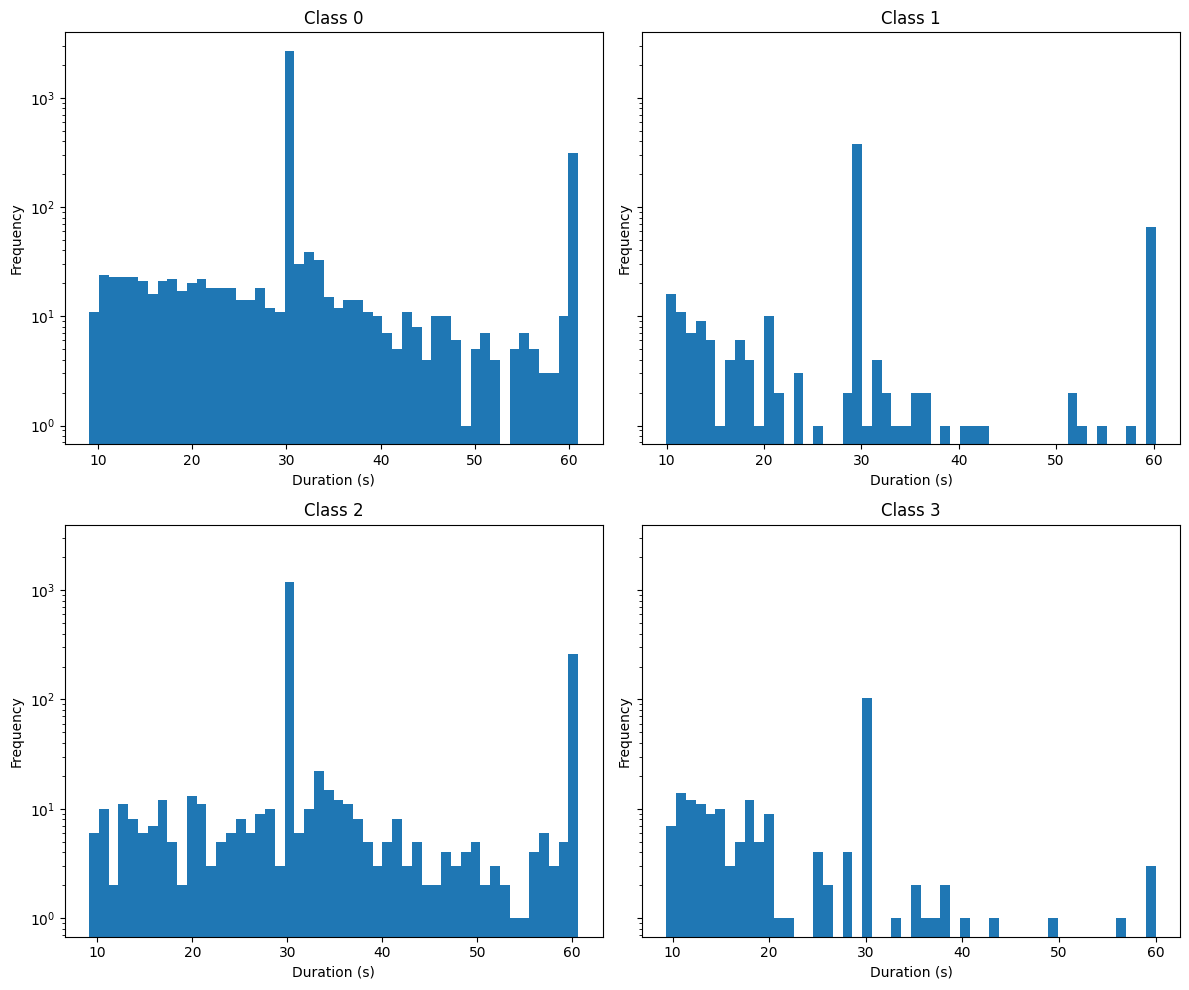

In [4]:
classes = np.unique(y_train[0])
n_classes = len(classes)
y_train_py = y_train[0].values

rows = int(np.ceil(n_classes / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, cls in enumerate(classes):
    ax = axes[i]
    ax.hist(durations[y_train_py == cls], bins=50)
    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")

# Hide empty axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Most ECG signals last 30 or 60 seconds across all classes, but this trend is less clear for signals that are classified as noise only. However, for tachycardic ECG signals, there are few examples with durations between 30 and 60 seconds, and there are also gaps between 20 and 30 seconds — unlike healthy signals, which show a broad distribution of durations with many examples across the entire range.

A similar pattern emerges when comparing abnormal signals to pure noise. The abnormal signals are more evenly distributed across durations from 10 to 30 and 30 to 60 seconds, with clear peaks at 30 and 60 seconds. In contrast, noise signals show gaps in the 20 to 30 and 30 to 60 second ranges.

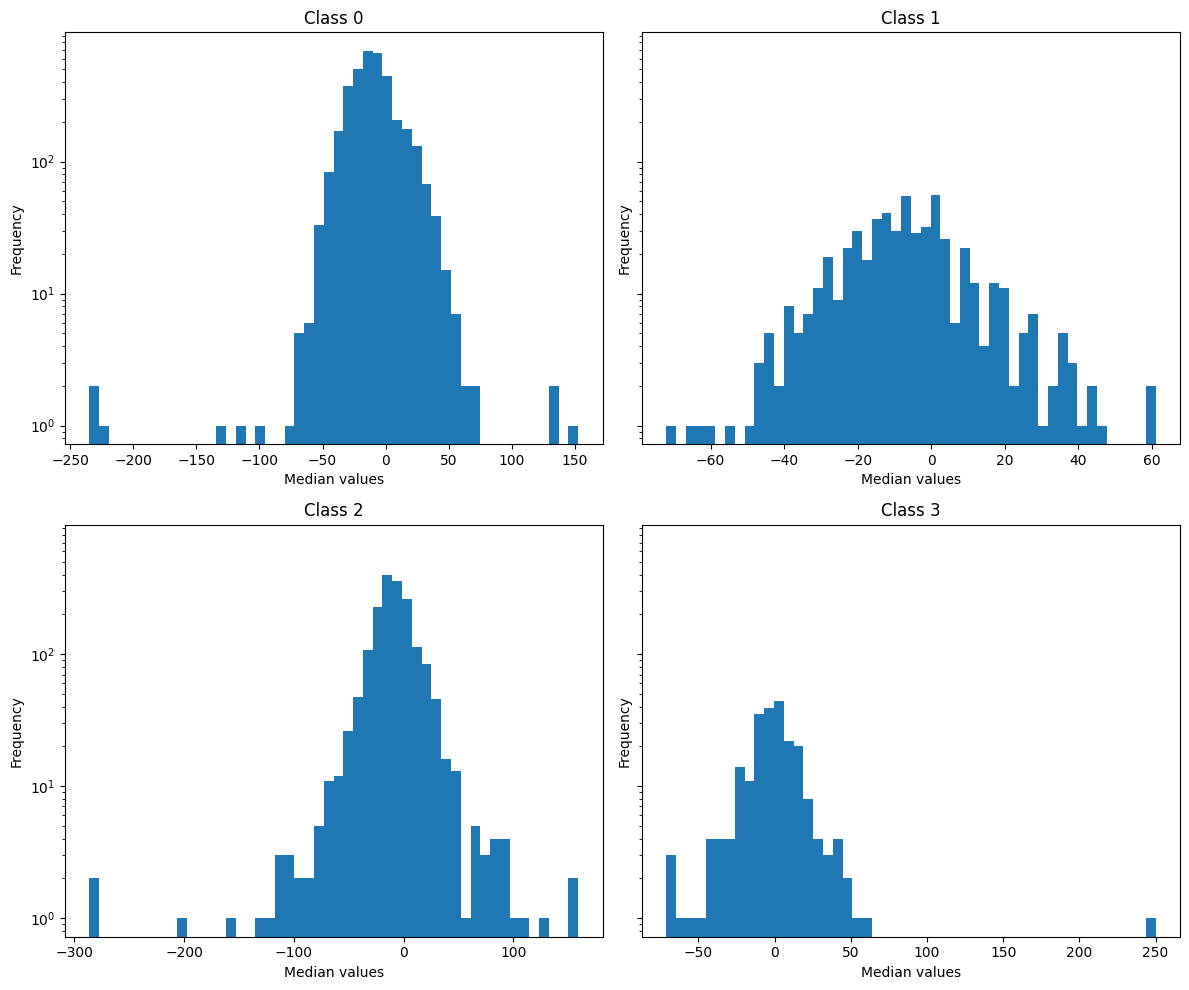

In [5]:
medians = [np.median(x) for x in X_train]
mins = [np.min(x) for x in X_train]
maxs = [np.max(x) for x in X_train]
deviation = [np.std(x) for x in X_train]  # Corrected typo: devi*a*ton → deviation

fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)
axes = axes.flatten()

for i, cls in enumerate(np.unique(y_train)):
    ax = axes[i]
    ax.hist(np.array(medians)[y_train_py == cls], bins=50)
    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Median values")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")

plt.tight_layout()
plt.show()

Now we are looking at the values that most commonly appear in each electrocardiogram. We can see that for healthy ECGs, there are quite a few cases where the median value falls in extreme ranges. The same holds true for the other classes — except for the noise class.

However, these extreme values differ between classes. For healthy signals, the extremes are around -250 and 150, but for tachycardic signals, the extremes are only between -60 and 60 — a significant difference. In signals with other abnormal patterns, the extreme values are again broader, ranging from -300 to 120.

If we disregard those extreme values, all classes behave fairly normally — except for the noise class, which is skewed to the right.

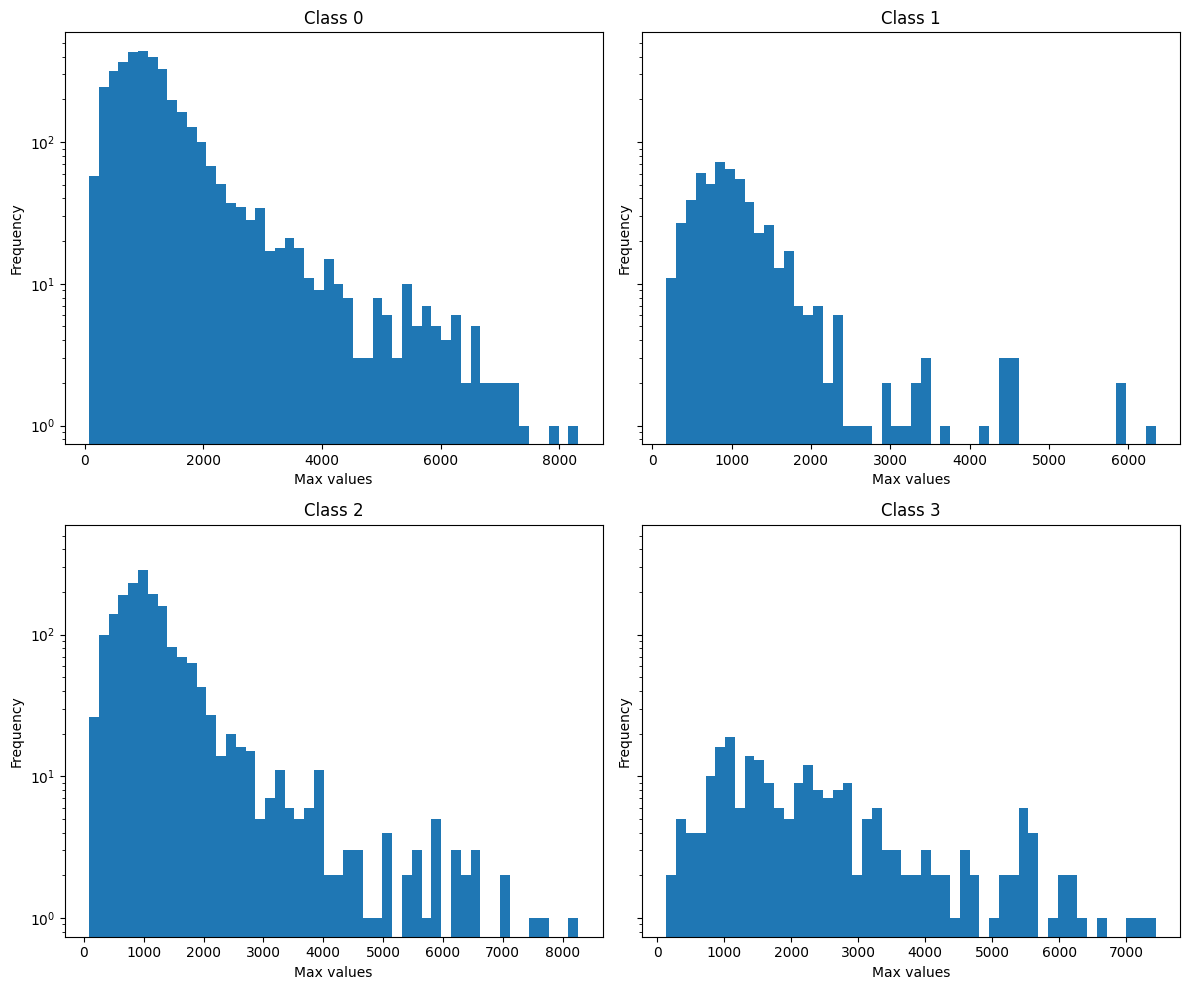

In [6]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, cls in enumerate(np.unique(y_train)):
    
    ax = axes[i]
    
    ax.hist(np.array(maxs)[y_train_py == cls], bins=50)
    
    ax.set_title(f"Class {cls}")
    
    ax.set_xlabel("Max values")
    
    ax.set_ylabel("Frequency")
    
    ax.set_yscale("log")
    
plt.tight_layout()
plt.show()

This plot closely matches the previous one, as the maximum values in most tachycardic ECGs almost never exceed 5000 — unlike the healthy ones and those with other abnormalities. However, these three classes once again share a similar distribution, although this time they are right-skewed, and noise once again does not follow the same distribution as the others.

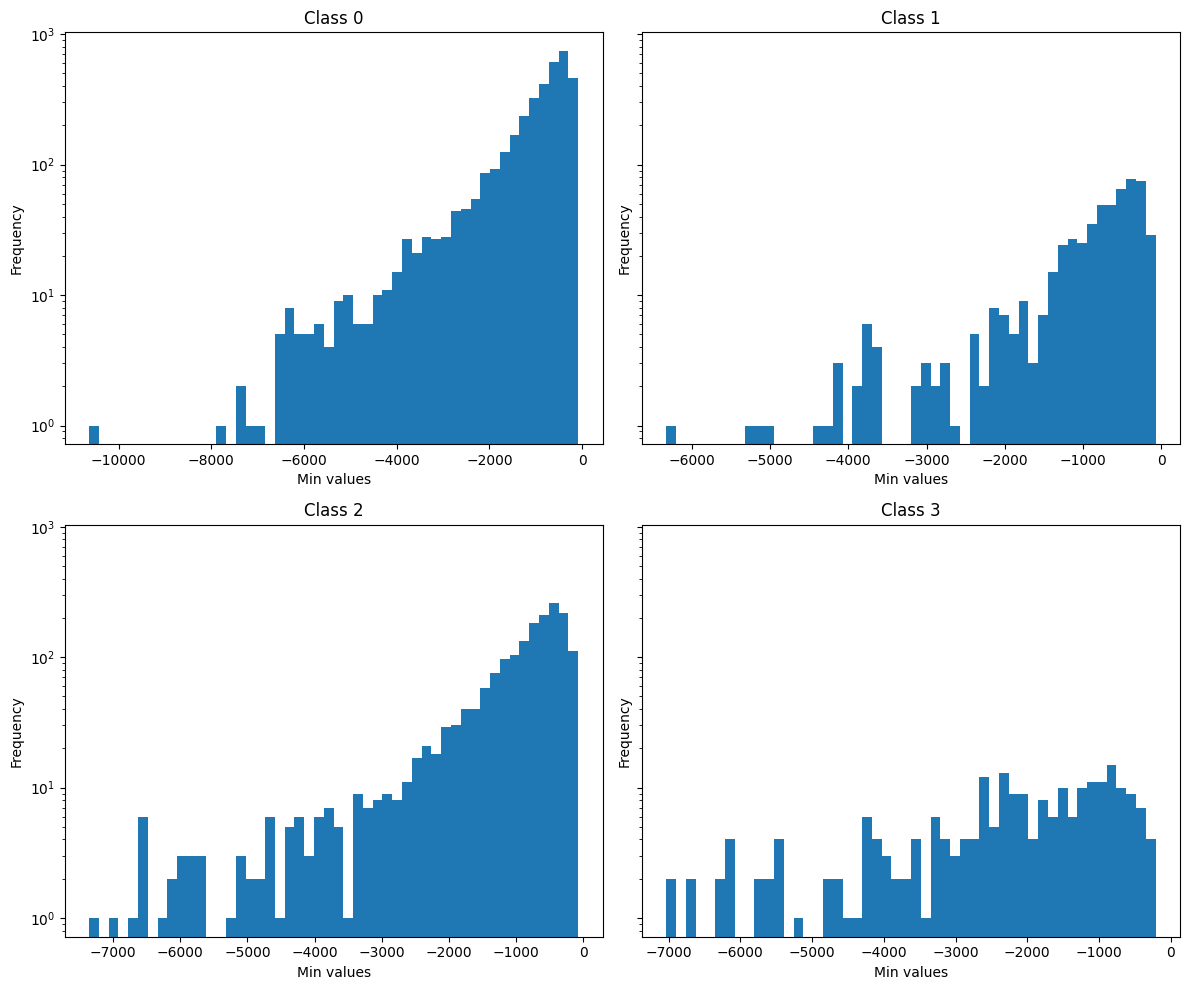

In [7]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, cls in enumerate(np.unique(y_train)):
    
    ax = axes[i]
    
    ax.hist(np.array(mins)[y_train_py == cls], bins=50)
    
    ax.set_title(f"Class {cls}")
    
    ax.set_xlabel("Min values")
    
    ax.set_ylabel("Frequency")
    
    ax.set_yscale("log")
    
plt.tight_layout()
plt.show()

This plot also corresponds with the previous two. The tachycardia ECG class has most of its minimum values between 0 and -4000, while the healthy and other abnormal classes range from 0 to -8000 and -7000, respectively. All of these show a left-skewed distribution. For the noise class, no skewed distribution is observed; instead, it appears more uniform.

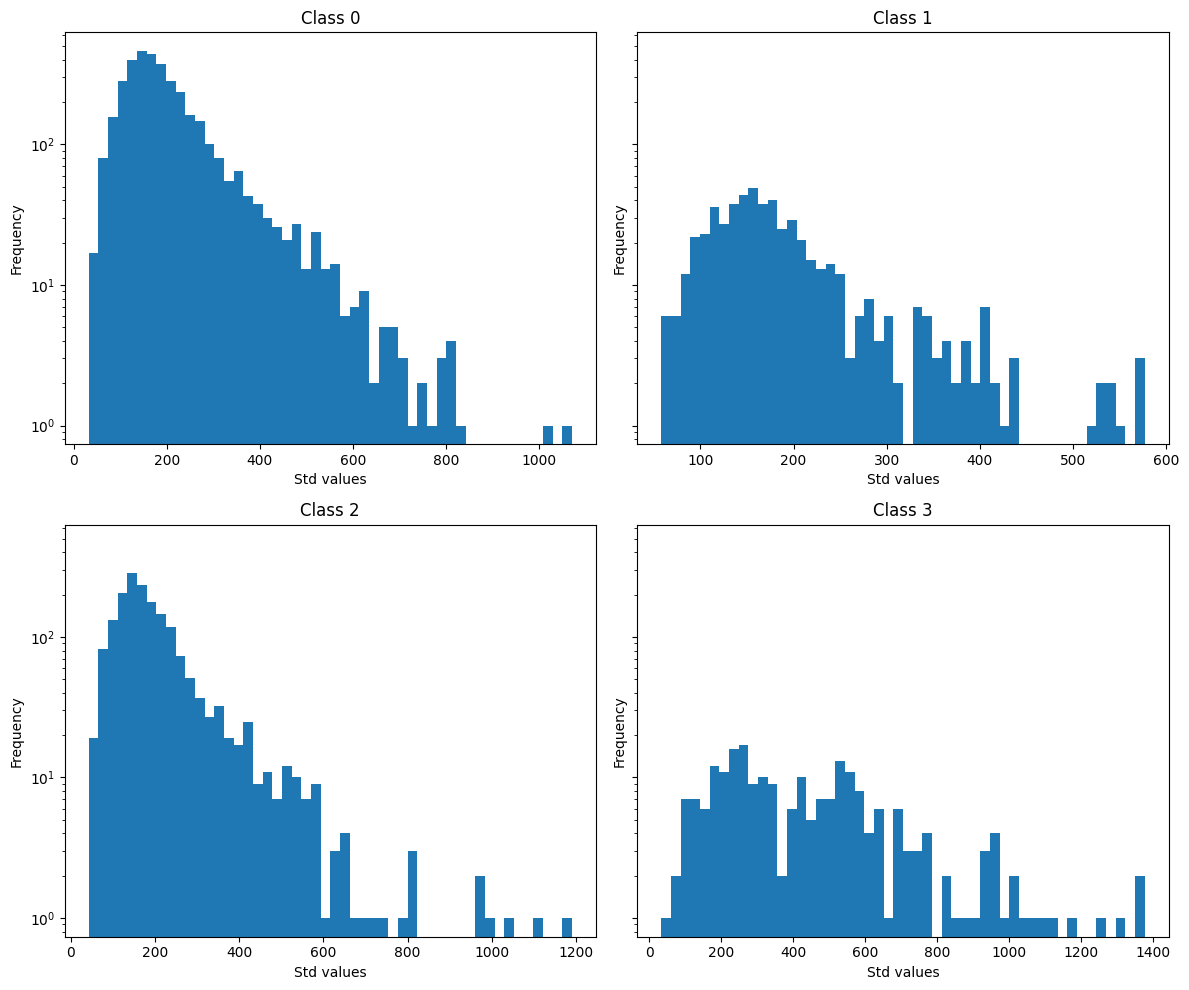

In [8]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, cls in enumerate(np.unique(y_train)):
    
    ax = axes[i]
    
    ax.hist(np.array(deviation)[y_train_py == cls], bins=50)
    
    ax.set_title(f"Class {cls}")
    
    ax.set_xlabel("Std values")
    
    ax.set_ylabel("Frequency")
    
    ax.set_yscale("log")
    
plt.tight_layout()

plt.show()

In conclusion, we have imbalanced classes, with many more recordings for the healthy ECGs. The first three classes have similar distributions for the mean, minimum, and maximum values, although the difference lies in the extreme values they reach. The noise recordings show a very different distribution in these cases.

Finally, the duration of the electrocardiograms in each class is mostly 30 or 60 seconds, but with the distinction that the healthy and other abnormal classes have durations spread across a wide range, whereas for tachycardia and noise, most durations are concentrated at 30 or 60 seconds.

In [ ]:
X_train, X_val, lengths_train, lengths_val, y_train, y_val = stratified_split_pad_torch(
    X_train, y_train
)

print(X_train.shape, y_train.shape)


class EDGCDataset(torch.utils.data.Dataset):

    def __init__(self, X, lengths, y):

        self.X = X

        self.lengths = lengths

        self.y = y

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):

        return self.X[idx], self.lengths[idx], self.y[idx]


train_dataset = EDGCDataset(X_train, lengths_train, y_train)
val_dataset = EDGCDataset(X_val, lengths_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

[🔁] Training on reduced dataset
X_train: torch.Size([1545, 18286])
lengths_train: torch.Size([1545])
y_train: torch.Size([1545])
X_val: torch.Size([615, 18286])
lengths_val: torch.Size([615])
y_val: torch.Size([615, 1])


# Model Definition

## ECGNet Model Architecture

The `ECGNet` class implements a neural network for ECG signal classification. The architecture consists of:

- **Spectrogram transformation**: Converts raw ECG signals into spectrograms using Short-Time Fourier Transform (STFT).
- **Convolutional layers**: Two sequential 2D convolutional layers with ReLU activations and max pooling, which extract spatial features from the spectrogram.
- **Recurrent layer**: An LSTM layer processes the sequence of features, capturing temporal dependencies.
- **Fully connected layer**: The final linear layer maps the LSTM output to the target number of classes.

The model expects ECG signals and their lengths as input, and produces class logits for classification tasks.

The `ECGNet` class is implemented on the module /models/model_1.py  

In [ ]:
from src.models.model_1 import ECGNet
from src.models.hyperparamter_tunning import hyperparameter_search

In [11]:
signal_length = X_train_pad.shape[1] if use_reduced_data else X_train.shape[1]
model = ECGNet(num_classes=4, signal_length=signal_length)


print(f"X_train: {X_train_pad.shape}")
print(f"lengths_train: {lengths_train_reduced.shape}")
print(f"y_train: {y_train_tensor.shape}")
     

X_train: torch.Size([1545, 18286])
lengths_train: torch.Size([1545])
y_train: torch.Size([1545])


In [ ]:
print(f"X_train: {X_train.shape}")
print(f"lengths_train: {lengths_train.shape}")
print(f"y_train: {y_train.shape}")

cpu
Epoch 1/20 - Train Loss: 1.3984 - Train F1: 0.1295 - Val Loss: 1.3483 - Val F1: 0.1113
Epoch 2/20 - Train Loss: 1.2879 - Train F1: 0.2077 - Val Loss: 1.2796 - Val F1: 0.1375
Epoch 3/20 - Train Loss: 1.2211 - Train F1: 0.2268 - Val Loss: 1.2443 - Val F1: 0.1356
Epoch 4/20 - Train Loss: 1.1480 - Train F1: 0.2329 - Val Loss: 1.1602 - Val F1: 0.2311
Epoch 5/20 - Train Loss: 1.1111 - Train F1: 0.2036 - Val Loss: 1.1371 - Val F1: 0.2427
Epoch 6/20 - Train Loss: 1.0942 - Train F1: 0.1988 - Val Loss: 1.0960 - Val F1: 0.2225
Epoch 7/20 - Train Loss: 1.0823 - Train F1: 0.2126 - Val Loss: 1.0947 - Val F1: 0.2609
Epoch 8/20 - Train Loss: 1.0537 - Train F1: 0.2178 - Val Loss: 1.0696 - Val F1: 0.2296


### 🔍 Hyperparameter Search and Model Selection

In this section, we perform **hyperparameter tuning** to improve the performance of our machine learning models.

When training neural networks, model performance is highly sensitive to hyperparameters such as the number of layers, hidden units, learning rate, dropout rate, and more. Manually selecting these values is inefficient and often suboptimal. Therefore, we use a **grid search strategy** to systematically explore combinations of hyperparameter values.

---

#### ✅ Why Hyperparameter Tuning?

- Different combinations can lead to **very different results**, even with the same architecture.
- Some configurations may **overfit** or **underfit**, while others may **generalize better**.
- Automated tuning helps us identify the **best performing model** on the validation set without manual trial-and-error.

---

#### ⚙️ How it Works

1. We define a **search space**, i.e., a dictionary of hyperparameter values to test.
2. We generate all **combinations** using Cartesian product (`itertools.product`).
3. For each combination:
   - Initialize the model with the current hyperparameters.
   - Train it for a fixed number of epochs on the training set.
   - Evaluate its performance on the validation set using **F1-score** and **loss**.
4. Store and compare results, selecting the configuration that performs **best on validation data**.

This process is repeated for each of the two model architectures used in this project:

- A **CNN-LSTM hybrid** based on time-frequency STFT features.
- A **Temporal Convolutional Network (TCN)** using a stacked 1D convolutional architecture.

---

By applying this strategy, we ensure our final models are both **well-tuned** and **generalizable**, which is essential for real-world performance.


In [ ]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    "lst_hidden_size": [32, 64, 128],
    
    "learning_rate": [.01, 0.001, 0.0005],
    
    "dropout": [0.1, 0.2, .5],
}
fixed = {
    "num_classes": 4,
    "signal_length": X_train.shape[1],
    "n_fft": 512,
    "hop_length": 256,
    "conv1_padding": 1,
    "conv2_padding": 1,
    "conv1_kernel": 3,
    "conv2_kernel": 3,
    "lstm_num_layers": 1,
    "conv1_channels": 32,
    "conv2_channels": 32
}

results = hyperparameter_search(
    ECGNet,
    param_grid,
    fixed,
    device=device,
    epochs=7,
    train_loader=train_loader,
    val_loader=val_loader,
)

### 🧪 Best Hyperparameter Configuration for ECGNet

After performing an extensive grid search over several key hyperparameters of the `ECGNet` architecture, the best-performing configuration (based on validation F1-score) was identified as:

- `conv1_channels = 32`
- `conv2_channels = 32`
- `lst_hidden_size = 128`
- `lstm_num_layers = 2`
- `learning_rate = 0.001`

This combination yielded the highest balance between training and validation performance, indicating that the model can generalize well without overfitting.

---

### 🚀 Final Training Setup

With the optimal hyperparameters selected, we now proceed to **train the final version of ECGNet** using a larger number of epochs (50) to fully exploit the model's capacity:


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGNet(
    num_classes=4,
    n_fft=512,
    hop_length=256,
    conv1_padding=1,
    conv2_padding=1,
    conv1_kernel=3,
    conv2_kernel=3,
    lstm_num_layers=1,
    conv1_channels=32,
    conv2_channels=32,
    lst_hidden_size=128,
    dropout=0.1,
    signal_length=X_train.shape[1],
    device=device,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion, augment_data=False, device=device)

history = trainer.fit(train_loader, val_loader, epochs=50)

train_loss, train_f1 = trainer.evaluate(train_loader)

val_loss, val_f1 = trainer.evaluate(val_loader)

print(train_f1, val_f1)

### 🔍 Hyperparameter Search and Model Selection (TCN + STFT)

In this section, we perform **hyperparameter tuning** for the `TCN_STFT_Classifier` model, which combines a Temporal Convolutional Network (TCN) with a Short-Time Fourier Transform (STFT) feature extraction step. The goal is to identify the best-performing configuration of this architecture on the validation set.

---

#### ⚙️ How it Works

1. We define a **grid of hyperparameters** to test, including:
   - `dropout` rates
   - TCN `hidden_channels` per layer
   - `learning_rate`
   - STFT parameters: `n_fft` and `hop_length`
2. Using `itertools.product`, we generate all possible **combinations** from this grid.
3. For each combination:
   - Instantiate the model with the current hyperparameters.
   - Train it for a fixed number of epochs (e.g., 10) on the training set.
   - Evaluate its performance using **F1-score** and **loss** on the validation set.
4. Track the best configuration based on **validation F1-score**.

---

This tuning process ensures that our TCN model, augmented with time-frequency features from STFT, is both **optimized** and **robust** to overfitting or underfitting. It complements the tuning process performed on our first model (`ECGNet`), allowing us to compare both architectures fairly under their best conditions.


In [ ]:
from src.models.model_2 import TCN_STFT_Classifier


param_grid = {
    # Configuraciones donde len(hidden_channels) == num_levels
    
        'hidden_channels': [[64,128,128,128],[128,128,128,128]],
    'dropout': [0.1, 0.2, 0.3],
    'kernel_size': [3, 5],
    'num_levels': [3,4]
}


fixed = {
    "num_classes": 4,
    "n_fft": 256,
    "hop_length": 128,
    "kernel_size": 3,
    "learning_rate" : .001,
}

results = hyperparameter_search(
    TCN_STFT_Classifier,
    param_grid,
    fixed,
    device=device,
    epochs=5,
    train_loader=train_loader,
    val_loader=val_loader,
)

### 🏁 Final Model Selection: (TCN + STFT)

After conducting an extensive grid search over multiple combinations of hyperparameters, we identified the **best-performing configuration** for the `(TCN + STFT)` model.

---

#### 🔧 Best Hyperparameters Found

- `conv1_channels = 32`
- `conv2_channels = 32`
- `lst_hidden_size = 128`
- `lstm_num_layers = 1`
- `learning_rate = 0.001`

These hyperparameters achieved the **highest F1-score** on the validation set among all tested configurations.

---

#### 🚀 Final Training Phase

Using this optimal setup, we now train the final version of the `ECGNet` model using **50 epochs** to allow the model to fully converge and leverage the learned configuration. This final model is expected to yield improved generalization performance and serve as a strong baseline for comparison against the second architecture (`TCN_STFT_Classifier`).

In [ ]:
from src.models.model_2 import TCN_STFT_Classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCN_STFT_Classifier(
    num_classes=4,
    hop_length = 128,
    n_fft = 256,
    kernel_size = 3, 
    hidden_channels=  [64, 128, 128],
    dropout = 0.2,
    num_levels = 3,
    device=device,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion, augment_data=False, device=device)

history = trainer.fit(train_loader, val_loader, epochs=50)

train_loss, train_f1 = trainer.evaluate(train_loader)

val_loss, val_f1 = trainer.evaluate(val_loader)

print(train_f1, val_f1)

## Lets use augment data for improving performance of the model training. First with ECG architechture. 

In [ ]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    "lst_hidden_size": [32, 64, 128],
    
    "learning_rate": [.01, 0.001, 0.0005],
    
    "dropout": [0.1, 0.2, .5],
}
fixed = {
    "num_classes": 4,
    "signal_length": X_train.shape[1],
    "n_fft": 512,
    "hop_length": 256,
    "conv1_padding": 1,
    "conv2_padding": 1,
    "conv1_kernel": 3,
    "conv2_kernel": 3,
    "lstm_num_layers": 1,
    "conv1_channels": 32,
    "conv2_channels": 32
}

results = hyperparameter_search(
    ECGNet,
    param_grid,
    fixed,
    device=device,
    epochs=7,
    train_loader=train_loader,
    val_loader=val_loader,
    augmented_data = True
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGNet(
    num_classes=4,
    n_fft=512,
    hop_length=256,
    conv1_padding=1,
    conv2_padding=1,
    conv1_kernel=3,
    conv2_kernel=3,
    lstm_num_layers=1,
    conv1_channels=32,
    conv2_channels=32,
    lst_hidden_size=128,
    dropout=0.1,
    signal_length=X_train.shape[1],
    device=device,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion, augment_data=True, device=device)

history = trainer.fit(train_loader, val_loader, epochs=50)

train_loss, train_f1 = trainer.evaluate(train_loader)

val_loss, val_f1 = trainer.evaluate(val_loader)

print(train_f1, val_f1)

In [ ]:
from src.models.model_2 import TCN_STFT_Classifier


param_grid = {
    # Configuraciones donde len(hidden_channels) == num_levels
    
        'hidden_channels': [[64,128,128,128],[128,128,128,128]],
    'dropout': [0.1, 0.2, 0.3],
    'kernel_size': [3, 5],
    'num_levels': [3,4]
}


fixed = {
    "num_classes": 4,
    "n_fft": 256,
    "hop_length": 128,
    "kernel_size": 3,
    "learning_rate" : .001,
}

results = hyperparameter_search(
    TCN_STFT_Classifier,
    param_grid,
    fixed,
    device=device,
    epochs=5,
    train_loader=train_loader,
    val_loader=val_loader,
    augmented_data = True
)

In [ ]:
from src.models.model_2 import TCN_STFT_Classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = TCN_STFT_Classifier(
    num_classes=4,
    hop_length = 128,
    n_fft = 256,
    kernel_size = 5, 
    hidden_channels=  [128, 128, 128, 128],
    dropout = 0.1,
    num_levels = 3,
    device=device,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion, device=device, augment_data = True)

history = trainer.fit(train_loader, val_loader, epochs=50)

train_loss, train_f1 = trainer.evaluate(train_loader)

val_loss, val_f1 = trainer.evaluate(val_loader)

print(train_f1, val_f1)